# Simple Poisson Processes

Jumpax simulates jump processes where the transition rate (intensity/propensity) can depend on the current state `u`, parameters `p`, and time `t`. When a jump occurs, we apply an update (affect) to the state.


In [2]:
import jax
import jax.numpy as jnp
import jumpax as jx
import matplotlib.pyplot as plt

## Constant Rate Jumps

We simulate a Poisson counting process with constant rate `λ`.

- `rate(t, u, p)` returns `p["lam"]` (constant intensity).
- `affect(...)` increments `u[0]` by 1 at each jump.


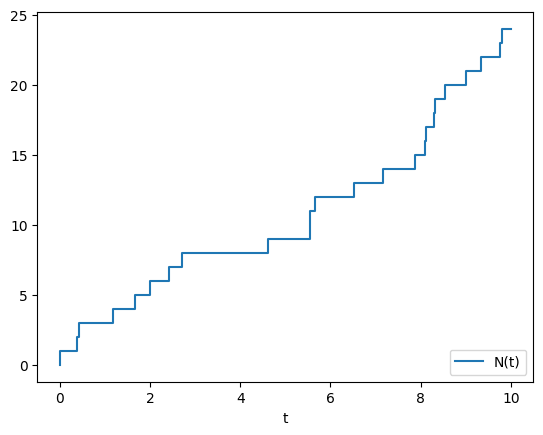

In [4]:
rate = lambda t, u, p: jnp.array([p["lam"]])

affect = jx.StatelessAffect(lambda t, u, p: jnp.expand_dims(u.at[0].add(1), axis=0))

crj = jx.ConstantRateJump(rate, affect)

u0 = jnp.array([0])
p = {"lam": 2.0}
t0, t1 = 0.0, 10.0
key = jax.random.key(0)

solver = jx.SSA()
save = jx.Save(states=True, reaction_counts=True)
sol = jx.solve(crj, solver, save, u0, t0=t0, t1=t1, args=p, key=key)

mask = jnp.isfinite(sol.ts)
ts = sol.ts[mask]
us = sol.us[mask]

plt.figure()
plt.step(ts, us[:, 0], where="post", label="N(t)")
plt.xlabel("t")
plt.legend(loc="lower right")
plt.show()

Add a death process with rate `μ * u[0]`, and track total deaths in `u[1]`.

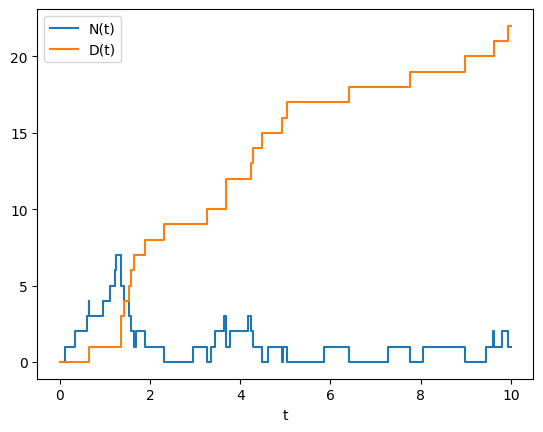

In [3]:
rate = lambda t, u, p: jnp.array([p["lam"], p["mu"] * u[0]])


def _affect_bd(t, u, p):
    u_birth = u.at[0].add(1)
    u_death = u.at[0].add(-1)
    u_death = u_death.at[1].add(1)
    return jnp.stack((u_birth, u_death))


affect = jx.StatelessAffect(_affect_bd)
crj = jx.ConstantRateJump(rate, affect)

u0 = jnp.array([0, 0])
p = {"lam": 2.0, "mu": 1.5}
t0, t1 = 0.0, 10.0
key = jax.random.key(1)

solver = jx.SSA()
save = jx.Save(states=True, reaction_counts=True)
sol = jx.solve(crj, solver, save, u0, t0=t0, t1=t1, args=p, key=key)

mask = jnp.isfinite(sol.ts)
ts = sol.ts[mask]
us = sol.us[mask]

plt.figure()
plt.step(ts, us[:, 0], where="post", label="N(t)")
plt.step(ts, us[:, 1], where="post", label="D(t)")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.show()

Simulate a compound Poisson process with random jumps $C_i \in \{-1,1\}$. Keep $N(t)=u[0]$ and $G(t)=u[1]$. The randomness lives in an `aggregator_state` carrying a key.


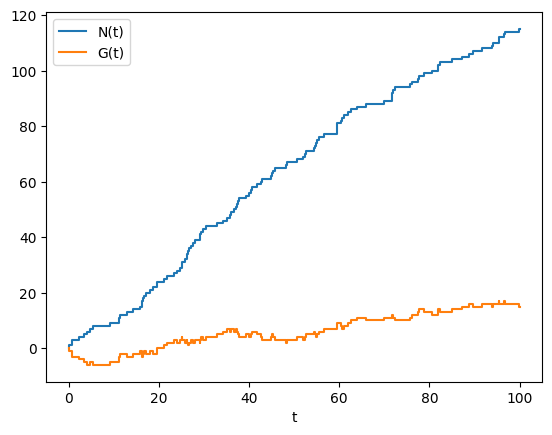

In [3]:
rate3 = lambda t, u, p: jnp.array([p["lam"]])


class Affect3(jx.AbstractAffect):
    def init(self, u, args, key):
        return key

    def __call__(self, t, u, p, aggregator_state):
        key = aggregator_state
        key, sub = jax.random.split(key)
        step = jax.random.choice(sub, jnp.array([-1, 1], dtype=u.dtype))
        u_new = u.at[0].add(1)
        u_new = u_new.at[1].add(step)
        return jnp.expand_dims(u_new, axis=0), key


affect3 = Affect3()
crj = jx.ConstantRateJump(rate3, affect3)

u0 = jnp.array([0, 0])
p = {"lam": 1.0}
t0, t1 = 0.0, 100.0
key = jax.random.key(0)

solver = jx.SSA()
save = jx.Save(states=True, reaction_counts=True)
sol = jx.solve(crj, solver, save, u0, t0=t0, t1=t1, args=p, key=key)

mask = jnp.isfinite(sol.ts)
ts = sol.ts[mask]
us = sol.us[mask]

plt.figure()
plt.step(ts, us[:, 0], where="post", label="N(t)")
plt.step(ts, us[:, 1], where="post", label="G(t)")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.show()